In [1]:
import glob
import os
import pandas as pd
import numpy as np
import subprocess

# general imports
from pathlib import Path

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, SmoothL1Loss
from torch.optim import Adam, SGD, lr_scheduler, LBFGS, RAdam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
from adabelief_pytorch import AdaBelief
#from torchviz import make_dot

In [2]:
def generate_cdr1_to_cdr3_pdb(path):
    with open(path, 'r') as f: # needs to be Chothia-numbered
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
        h_range = range(26, 103)
        l_range = range(24, 98)
        chain_range = slice(21, 22)
        res_range = slice(23, 26)
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        idx_list = list(header_lines_important)
        new_path = path[:-4] + '_CDR1_to_CDR3' + path[-4:]
        
        # Getting the names of the heavy and light chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
            h_chain = line[h_pos:h_pos+1]
            l_chain = line[l_pos:l_pos+1]
            
            # Obtaining the CDR1 to CDR3 lines for both chains
            for i, line in enumerate(content[header_lines:]):
                if (line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range) or (line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range):
                    idx_list.append(i+header_lines)
            
                    
    # Creating new file
    with open(new_path, 'w') as f_new:
        f_new.writelines([content[l] for l in idx_list])

In [3]:
# Getting entries with affinity and antigen information
df = pd.read_csv('sabdab_summary_all.tsv', sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
df.drop_duplicates(keep='first', inplace=True)
df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
df = df[(df.affinity.notna()) & (df.affinity != 'None')]
entries = list(df['pdb'])
affinity = list(df['affinity'])
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
dccm_map_path = 'dccm_maps/'

# Uncomment to generate
#for entry in entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input)
#    subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path)], shell=True, stdout=open(os.devnull, 'wb'))
    
#    if os.path.exists(path):
#        os.remove(path)

In [4]:
# loading training images
imgs = []
kds = []
labels = []
data_path = '/Users/kevinmicha/Documents/PhD/SAbDab/' + dccm_map_path
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
for f in file_paths:
    pdb_id = f[-8:-4]
    if pdb_id in entries:
        idx = entries.index(pdb_id)
        labels.append(pdb_id)
        imgs.append(np.load(f)[:80, :80])
        kds.append(np.log10(np.float32(affinity[idx])))

# converting the list to numpy array
train_x = np.array(imgs)
# defining the target
train_y = np.array(kds)

In [5]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.0001)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((392, 80, 80), (392,)), ((1, 80, 80), (1,)))

In [6]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
train_x = train_x.astype(np.float32)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([392, 1, 80, 80]), torch.Size([392, 1]))

In [7]:
len(list(train_x))

392

In [8]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, train_x.shape[2], train_x.shape[2])
val_x = val_x.astype(np.float32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(np.float32).reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([1, 1, 80, 80]), torch.Size([1, 1]))

In [14]:
class MultiLabelNN(Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = Conv2d(1, 16, 30)
        self.pool = MaxPool2d(2, 2)
        self.conv2 = Conv2d(16, 32, 3)
        self.relu = ReLU()
        self.fc1 = Linear(76832, 128)
        self.fc2 = Linear(128, 1)
        #self.fc3 = Linear(128, 64)
        #self.fc4 = Linear(64, 1)

    def forward(self, x):
       #shape of x is (b_s, 32,32,1)
        x = self.conv1(x) #shape of x is (b_s, 28,28,132)
        x = self.relu(x)
        #x = self.pool(x) #shape of x now becomes (b_s X 14 x 14 x 32)
        x = self.conv2(x) # shape(b_s, 10x10x64)
        x = self.relu(x)#size is (b_s x 10 x 10 x 64)
        x = x.view(x.size(0), -1) # shape of x is now(b_s*2, 3200)
        #this is the problem 
        #you can fc1 to be of shape (6400,1024) and that will work 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        #x = self.fc4(x)


        return x.float()


In [15]:
# defining the model
model = MultiLabelNN()
# defining the optimizer
optimizer = AdamW(model.parameters(), lr=8e-4)
#optimizer = AdaBelief(model.parameters(), lr=5e-5, eps=1e-16, betas=(0.9,0.999), weight_decouple=False, rectify=False)
#optimizer = SGD(model.parameters(), lr=8e-4)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, min_lr=3e-8, factor=1e-4)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

MultiLabelNN(
  (conv1): Conv2d(1, 16, kernel_size=(30, 30), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (fc1): Linear(in_features=76832, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [16]:
def train(epoch):
    model.train()
    tr_loss = 0
    batch_size = 64
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    
    permutation = torch.randperm(x_train.size()[0])

    for i in range(0,x_train.size()[0], batch_size):
        # clearing the Gradients of the model parameters
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        # prediction for training and validation set
        output_train = model(batch_x)
        output_val = model(x_val)

        # computing the training and validation loss
        loss_train = criterion(output_train, batch_y)
        loss_val = criterion(output_val, y_val)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        
        #scheduler.step(loss_val)
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
    train_losses.append(tr_loss)
    val_losses.append(loss_val)
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss: ', tr_loss, 'val loss :', loss_val)
    print(output_val)
    print(y_val)
        
    return tr_loss, loss_val


In [17]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [18]:
# defining the number of epochs
n_max_epochs = 200

# training the model
for epoch in range(n_max_epochs):
    tr_loss, val_loss = train(epoch)
    if tr_loss < 0.9 and val_loss < 1:
        break

Epoch :  1 	 train loss:  24.766252556625677 val loss : tensor(2.0435, grad_fn=<MseLossBackward0>)
tensor([[-4.7923]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  2 	 train loss:  6.777551689926458 val loss : tensor(7.6950, grad_fn=<MseLossBackward0>)
tensor([[-8.9958]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  3 	 train loss:  3.0053728453967037 val loss : tensor(1.9097, grad_fn=<MseLossBackward0>)
tensor([[-7.6038]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  4 	 train loss:  2.7725673597686145 val loss : tensor(2.4470, grad_fn=<MseLossBackward0>)
tensor([[-7.7861]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  5 	 train loss:  2.502322333199637 val loss : tensor(2.8452, grad_fn=<MseLossBackward0>)
tensor([[-7.9086]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  6 	 train loss:  2.7476915242720623 val loss : tensor(2.2673, grad_fn=<MseLossBackward0>)
tensor([[-7.7276]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  7 	

Epoch :  51 	 train loss:  2.1738735315751057 val loss : tensor(2.2441, grad_fn=<MseLossBackward0>)
tensor([[-7.7199]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  52 	 train loss:  2.5355891597514253 val loss : tensor(0.2238, grad_fn=<MseLossBackward0>)
tensor([[-6.6949]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  53 	 train loss:  2.2779871298342336 val loss : tensor(0.5233, grad_fn=<MseLossBackward0>)
tensor([[-6.9453]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  54 	 train loss:  2.957437904513612 val loss : tensor(2.8990, grad_fn=<MseLossBackward0>)
tensor([[-7.9245]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  55 	 train loss:  2.4968906324736926 val loss : tensor(2.3503, grad_fn=<MseLossBackward0>)
tensor([[-7.7549]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  56 	 train loss:  2.1053300001183333 val loss : tensor(1.0608, grad_fn=<MseLossBackward0>)
tensor([[-7.2518]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch

Epoch :  101 	 train loss:  1.840440964212223 val loss : tensor(0.3674, grad_fn=<MseLossBackward0>)
tensor([[-6.8280]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  102 	 train loss:  2.0381599348418566 val loss : tensor(0.3084, grad_fn=<MseLossBackward0>)
tensor([[-6.7772]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  103 	 train loss:  1.7892687466679786 val loss : tensor(2.6174, grad_fn=<MseLossBackward0>)
tensor([[-7.8397]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  104 	 train loss:  2.1323894383955975 val loss : tensor(1.3645, grad_fn=<MseLossBackward0>)
tensor([[-7.3900]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  105 	 train loss:  1.8160854845630878 val loss : tensor(1.4102, grad_fn=<MseLossBackward0>)
tensor([[-7.4094]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  106 	 train loss:  1.6316954067775182 val loss : tensor(0.7059, grad_fn=<MseLossBackward0>)
tensor([[-7.0620]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])

Epoch :  151 	 train loss:  1.2534216082825953 val loss : tensor(0.2568, grad_fn=<MseLossBackward0>)
tensor([[-6.7286]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  152 	 train loss:  1.3275707595202388 val loss : tensor(0.1925, grad_fn=<MseLossBackward0>)
tensor([[-6.6606]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  153 	 train loss:  1.463994366782052 val loss : tensor(0.6842, grad_fn=<MseLossBackward0>)
tensor([[-7.0490]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  154 	 train loss:  1.0556460205389528 val loss : tensor(0.1835, grad_fn=<MseLossBackward0>)
tensor([[-6.6502]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  155 	 train loss:  1.1686732428414481 val loss : tensor(0.1949, grad_fn=<MseLossBackward0>)
tensor([[-6.6633]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
Epoch :  156 	 train loss:  1.08785748968319 val loss : tensor(0.0543, grad_fn=<MseLossBackward0>)
tensor([[-6.4549]], grad_fn=<AddmmBackward0>)
tensor([[-6.2218]])
E

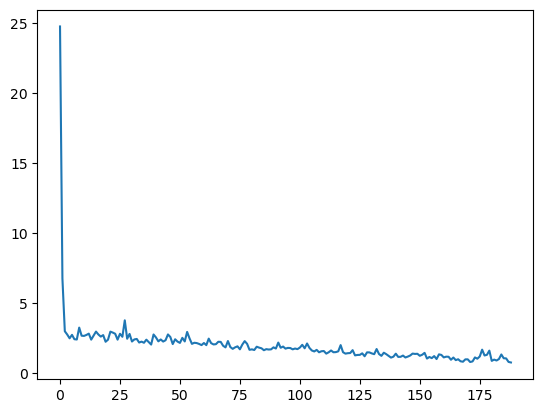

In [19]:
plt.plot([train_losses[i] for i in range(len(train_losses))])

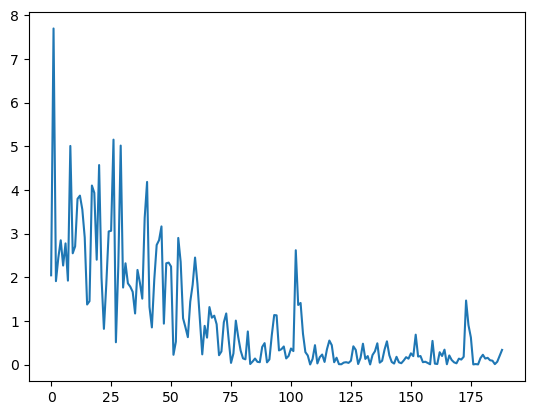

In [20]:
plt.plot([val_losses[i].detach().numpy() for i in range(len(val_losses))])

In [21]:
model(Variable(train_x[15:20]))

tensor([[-8.8976],
        [-8.0727],
        [-7.9355],
        [-8.9683],
        [-5.2687]], grad_fn=<AddmmBackward0>)

In [22]:
Variable(train_y[15:20])

tensor([[-8.2218],
        [-7.6402],
        [-7.5229],
        [-9.5229],
        [-5.5376]])

In [23]:
file_paths

['/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1a4k.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1axs.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1bj1.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1bvk.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1c12.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1ct8.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1cz8.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1d6v.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1dbb.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1dee.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1dl7.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1e6j.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1eo8.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1f4x.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1f4y.npy',
 '/Users/kevinmicha/Documents/PhD/SAbDab/dccm_maps/1f90.npy',
 '/Users

In [24]:
download_path = '/Users/kevinmicha/Downloads/'

test_sample = torch.from_numpy(np.load(download_path + '1t66.npy')[:train_x.shape[2], :train_x.shape[2]].reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [25]:
10**model(test_sample).detach().numpy()

array([[3.3190824e-07]], dtype=float32)

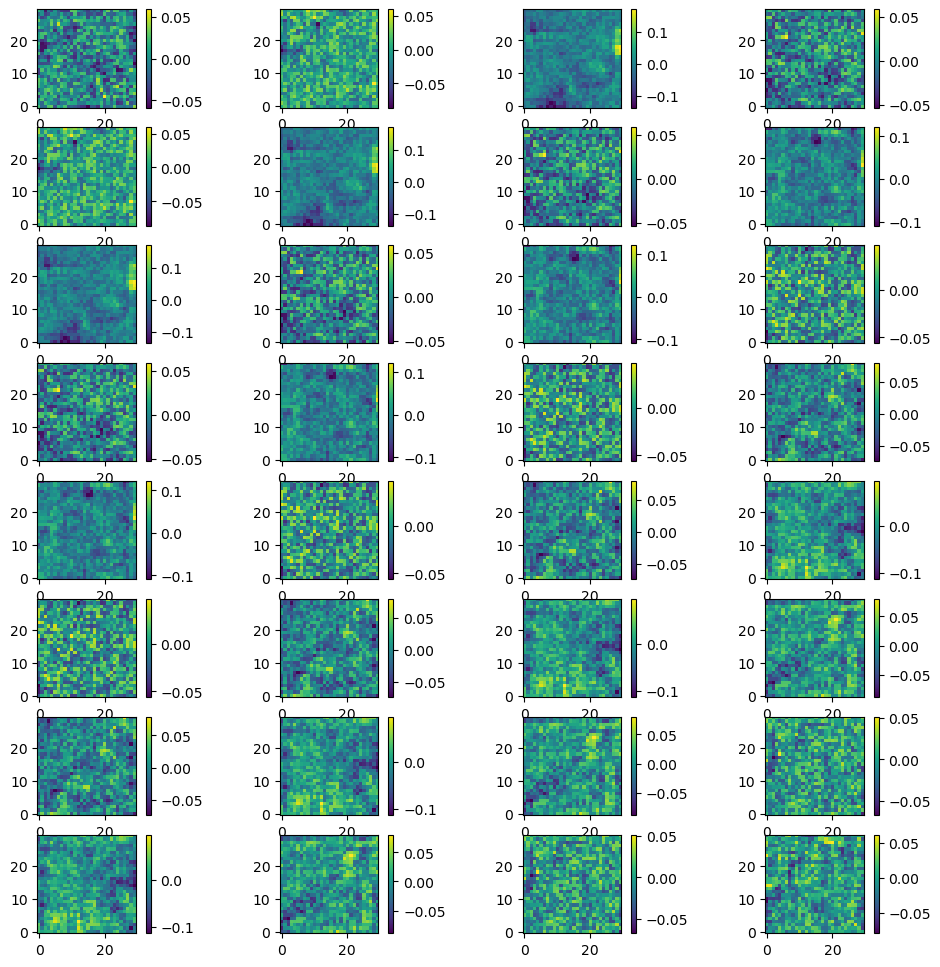

In [26]:
import itertools

fig, axs = plt.subplots(8, 4, figsize=(12, 12))

for i, j in itertools.product(range(8), range(4)):
    im = axs[i,j].imshow(model.conv1.weight.data.numpy()[i+j][0], origin='lower')
    plt.colorbar(im, ax=axs[i, j])

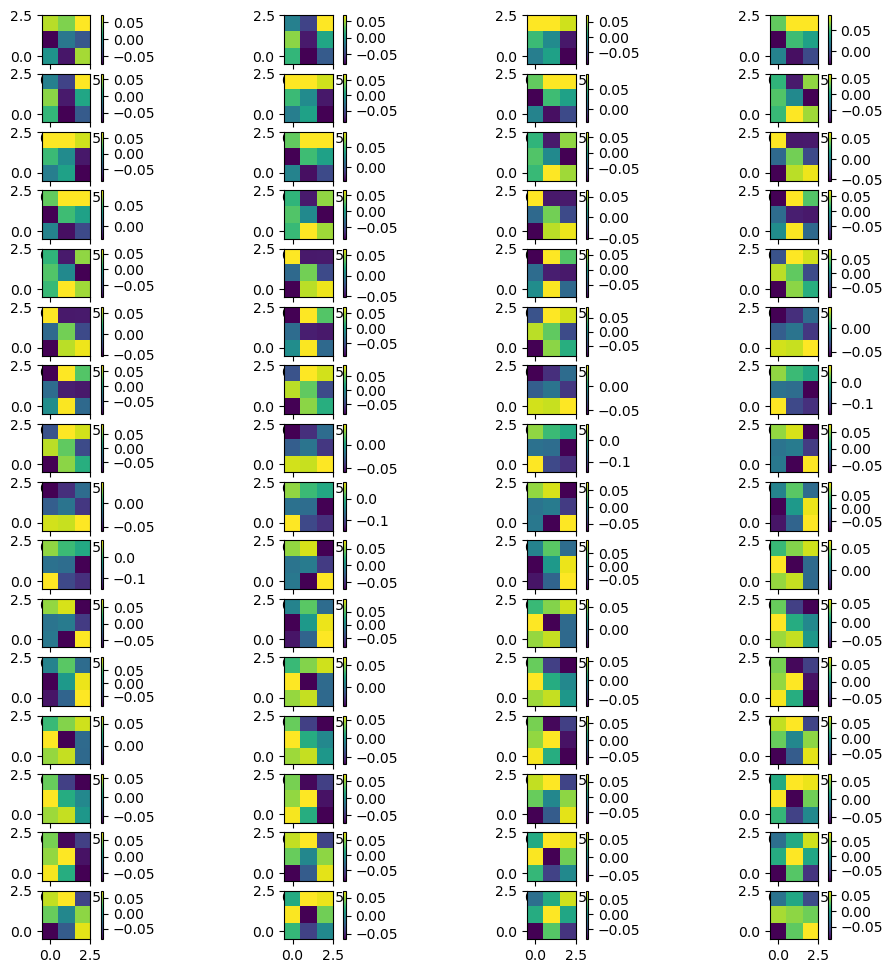

In [27]:
fig, axs = plt.subplots(16, 4, figsize=(12, 12))

for i, j in itertools.product(range(16), range(4)):
    im = axs[i,j].imshow(model.conv2.weight.data.numpy()[i+j][0], origin='lower')
    plt.colorbar(im, ax=axs[i, j])


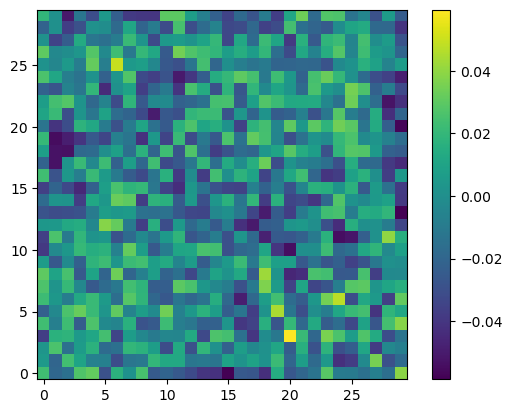

In [28]:
plt.imshow(np.mean(model.conv1.weight.data.numpy()[0,...], axis=0), origin='lower')
plt.colorbar()

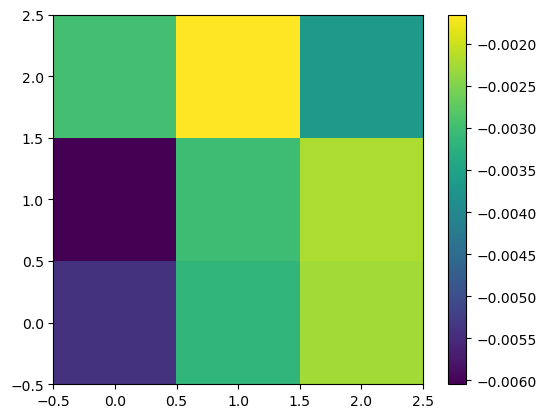

In [29]:
plt.imshow(np.mean(np.mean(model.conv2.weight.data.numpy(), axis=0), axis=0), origin='lower')
plt.colorbar()

In [ ]:
# Save Neural Network visualization

#x_val = Variable(val_x)
#model = MultiLabelNN()
#yhat = model(x_val)
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("attached", format="png")